# Learning pipeline

**Author**: Miguel Xochicale [@mxochicale](https://github.com/mxochicale)     
**Contributors**: Nhat Phung Tran Huy [@huynhatd13](https://github.com/huynhatd13); Hamideh Kerdegari [@hamidehkerdegari](https://github.com/hamidehkerdegari);  Alberto Gomez [@gomezalberto](https://github.com/)  


## History
* Feb2022: Adding initial models with small dataset   
* March2022: Improved datasets representation
* April2022: Adds dataloader for clips and videos
* May2022: Tidies VGG2D and VGG3D   
* June2022: Tidies basicVGG model and adds heuristics for hyperarameters 
* Week1, July2022: Integreate modules in source path
* Week2, July2022: Implements Tromp2022Net DOI: https://doi.org/10.1016/S2589-7500(21)00235-17
* Week3, July2022: Adds LeNet, AlexNet and VGGNets, MobileNetV1, MobileNetV2
* Week4, July2022: Adds ShuffleNetV1, ShuffleNetV2 and merge all to main!


## Summary
This notebook presents a learning pipeline to classify 4 chamber view from echocardiography datasets.

### How to run the notebook

1. Go to echocardiography repository path: `$HOME/repositories/echocardiography/`
2. Open echocardiography repo in pycharm and in the terminal type:
    ```
    git checkout master # or the branch
    git pull # to bring a local branch up-to-date with its remote version
    ```
3. Launch Notebook server  
    Go to you repository path: `cd $HOME/repositories/echocardiography/scripts/dataloaders` and type in the pycharm terminal:
    ```
    conda activate rt-ai-echo-VE 
    jupyter notebook
    ```
    which will open your web-browser.
    
    
### References
* "Proposed Regulatory Framework for Modifications to Artificial Intelligence/Machine Learning (AI/ML)-Based Software as a Medical Device (SaMD) - Discussion Paper and Request for Feedback". https://www.fda.gov/media/122535/download 
* https://nestedsoftware.com/2019/09/09/pytorch-image-recognition-with-convolutional-networks-4k17.159805.html 
* https://ai.stackexchange.com/questions/5769/in-a-cnn-does-each-new-filter-have-different-weights-for-each-input-channel-or
* Gomez A. et al. 2021 https://github.com/vital-ultrasound/lung/blob/main/multiclass_pytorch/datasets/LUSVideoDataset.py 
* Kerdegari H. et al. 2021 https://github.com/vital-ultrasound/lung/tree/main/multiclass_tensorflow
* https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/
* https://github.com/shanglianlm0525/PyTorch-Networks



# Jupyter Notebook

## 1. Setting imports and datasets paths

In [1]:
import os
import sys
import argparse
import yaml
from pathlib import Path
import json
import time

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#import matplotlib.animation as animation
from IPython.display import HTML #to be used with HTML(animation.ArtistAnimation().to_jshtml())
from tqdm import tqdm
import shutil

import numpy as np
import math
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, \
                            ConfusionMatrixDisplay, precision_recall_fscore_support
from datetime import datetime


from typing import Dict, List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch.utils.data import DataLoader
import torch.utils.data as Data
from torchinfo import summary
from torchvision import transforms, utils, models

from source.dataloaders.EchocardiographicVideoDataset import EchoClassesDataset
from source.helpers.various import concatenating_YAML_via_tags, \
                                    plot_dataset_classes, \
                                    split_train_validate_sets
from source.helpers.learning_pipeline import get_class_distribution, \
                                            plot_from_dict, \
                                            creating_pair_of_clips, \
                                            pair_clips_labels, \
                                            animate_clips
from source.models.learning_misc import train_loop, \
                                        test_loop

from source.models.architectures import basicVGG, TrompNet2022, \
        LeNet5_source00, LeNet5_source01, LeNet5_source02, \
        AlexNet_source00, AlexNet_source01, AlexNet_source02, AlexNet_source03, \
        MobileNetV1, MobileNetV2 
        #ShuffleNetV1, ShuffleNetV2 (require 3 channels of input images)

HOME_PATH = os.path.expanduser(f'~')
USERNAME = os.path.split(HOME_PATH)[1]

REPOSITORY_PATH='repositories/echocardiography'
FULL_REPO_PATH = HOME_PATH+'/'+REPOSITORY_PATH
FULL_REPO_MODEL_PATH = HOME_PATH +'/' + REPOSITORY_PATH + '/data/models'
CONFIG_FILES_PATH= REPOSITORY_PATH + '/scripts/config_files/users_paths_files'
YML_FILE =  'config_users_paths_files_username_' + USERNAME + '.yml'
FULL_PATH_FOR_YML_FILE = os.path.join(HOME_PATH, CONFIG_FILES_PATH, YML_FILE)
PATH_for_temporal_files = os.path.join(HOME_PATH, 'datasets/vital-us/echocardiography/temporal-files')

## Setting TRAINING_CURVES_PATH
#CURRENT_PATH=os.path.abspath(os.getcwd())
RESULTS_PATH='scripts/learning-pipeline/results'
TRAINING_CURVES_PATH = os.path.join(FULL_REPO_PATH, RESULTS_PATH)

## Setting FULL_PATH_FOR_YML_FILE
yaml.add_constructor('!join', concatenating_YAML_via_tags)  ## register the tag handler
with open(FULL_PATH_FOR_YML_FILE, 'r') as yml:
    config = yaml.load(yml, Loader=yaml.FullLoader)

## Printing Versions and paths
print(f'PyTorch Version: {torch.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')    
print(f'FULL_PATH_FOR_YML_FILE: {FULL_PATH_FOR_YML_FILE}' )
print(f'FULL_REPO_MODEL_PATH: {FULL_REPO_MODEL_PATH}' )
print(f'TRAINING_CURVES_PATH: {TRAINING_CURVES_PATH}' )


PyTorch Version: 1.9.0
Torchvision Version: 0.10.0a0
FULL_PATH_FOR_YML_FILE: /home/mx19/repositories/echocardiography/scripts/config_files/users_paths_files/config_users_paths_files_username_mx19.yml
FULL_REPO_MODEL_PATH: /home/mx19/repositories/echocardiography/data/models
TRAINING_CURVES_PATH: /home/mx19/repositories/echocardiography/scripts/learning-pipeline/results


## 2. Generate list text files for train and validate datasets

Edit config_users_paths_files_username_$USER.yml at '../config_files/users_paths_files/config_users_paths_files_username_template.yml' with the right paths and percentage of `ntraining`:  
```
#ECHODATASET_PATH = config['echodataset_path'] # Default
ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-GOOD'
TRAINING_SPLITTING = 0.8 #config['ntraining'] #Default
randomise_file_list: False
```

In [2]:
##############################
##### Setting up device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") #or "cuda:NN" can also be used e.g., "cuda:0"
print(f'Device: {DEVICE}')


### Trump et al. 2022 
##"We trained the models on 55487 images from 1145 individual echocardiograms (appendix pp 2–3)." 
##Appendix pp 2–3.
##AC4: TRAINING: total videos 740 total frames 9615; T
##      TESTING: total videos:64 total frames 1218                


##############################
## Setting ECHODATASET_PATH; 
#ECHODATASET_PATH = config['echodataset_path'] # Default

# ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-05-subjects'
    #"BATCH_SIZE_OF_CLIPS": 20,
    #"FRAMES_PER_CLIP": 1,
    #"Train Dataset Size": 720,
    #"Test Dataset Size": 320,
    #"Validation Dataset Size": 280,

#ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-10-subjects'
    #"BATCH_SIZE_OF_CLIPS": 20,
    #"FRAMES_PER_CLIP": 1,
    #"Train Dataset Size": 1280,
    #"Test Dataset Size": 560,
    #"Validation Dataset Size": 440,

ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-20-subjects'
    #"BATCH_SIZE_OF_CLIPS": 20,
    #"FRAMES_PER_CLIP": 1,
    #"Train Dataset Size": 2240,
    #"Test Dataset Size": 960,
    #"Validation Dataset Size": 720,

#ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-31-subjects'
    #"BATCH_SIZE_OF_CLIPS": 20,
    #"FRAMES_PER_CLIP": 1,
    #"Train Dataset Size": 3620,
    #"Test Dataset Size": 1540,
    #"Validation Dataset Size": 880,



#ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-in-verification40-49'



TRAINING_SPLITTING = 0.80 #config['ntraining'] #Default
FLAG_RANDOMISE_DATA=True #config['randomise_file_list'] #Default

split_train_validate_sets(  
                        ECHODATASET_PATH, #config['echodataset_path']
                        config['data_list_output_path'], 
                        TRAINING_SPLITTING,
                        FLAG_RANDOMISE_DATA
                        )

# PRETRANSFORM_IM_SIZE = [64, 64] #[650, 690] original pixel size for VenueGO
PRETRANSFORM_IM_SIZE = [128, 128] #[650, 690] original pixel size for VenueGO
# PRETRANSFORM_IM_SIZE = [256, 256] #[650, 690] original pixel size for VenueGO
# PRETRANSFORM_IM_SIZE = [512, 512] #[650, 690] original pixel size for VenueGO
# PRETRANSFORM_IM_SIZE = config['pretransform_im_size'] ##DEFAULT

### >> CHANGE DENSE LAYER FEATURES IN VGG3D
### >> `self.fc0 = nn.Linear(in_features=4194304, out_features=500) #128x128`

##############################
##### Experiments for Basic HYPERPARAMETER Heuristics 

#### TESTS
NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 1; BATCH_SIZE_OF_CLIPS = 13; 
#LEARNING_RATE= 0.00005; 


#################  LEARNING_RATE 
### EXPERIMENT 01,02,03,04
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 1; BATCH_SIZE_OF_CLIPS = 20; LEARNING_RATE= 0.00005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 20; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 20; LEARNING_RATE= 0.0000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 20; LEARNING_RATE= 0.00000005; 

#################  BATCH_SIZE_OF_CLIPS with LEARNING_RATE= 0.000005 as it is the best peformance of prevous LRs 
### EXPERIMENT 04,06,07,08
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 2; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 5; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 15; LEARNING_RATE= 0.000005; 

#################  NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP with LEARNING_RATE= 0.000005 and BATCH_SIZE_OF_CLIPS=10
### EXPERIMENT 09,10,11,12
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 2; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 7; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 13; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 20; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 

##TOADD
### * NUMBER_OF_FRAMES_AND PARTICPANTS
### * OPTIMISERS 

# LEARNING_RATE =Trial and Error with diffent values  0.00005; 0.0005; 0.005 and 0.000001; 0.00001; 0.0001; 0.001  


MAX_EPOCHS = 1000 #Alternatvely, make use of: config['max_epochs']


##############################
##### Setting up animation
interval_between_frames_in_milliseconds=33.3 ## 1/30=0.033333
frame_per_seconds_for_animated_frames=30


#SUBJECT_ID = '073'
#print(SUBJECT_ID)

### CUDA out of memory 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10
#PRETRANSFORM_IM_SIZE = [128, 128] 
#RuntimeError: CUDA out of memory. Tried to allocate 7.81 GiB (GPU 0; 15.74 GiB total capacity; 8.51 GiB already allocated; 5.05 GiB free; 8.53 GiB reserved in total by PyTorch)
## REBOOT MACHINE
#RuntimeError: CUDA out of memory. Tried to allocate 7.81 GiB (GPU 0; 15.74 GiB total capacity; 8.51 GiB already allocated; 5.13 GiB free; 8.53 GiB reserved in total by PyTorch)



##############################
## Setting labels
label_id = ('BKGR', '4CV')




Device: cuda
======= video_filenames: ('/01NVb-003-051/T1/01NVb-003-051-1 echo.mp4', '/01NVb-003-046/T1/01NVb-003-046-1 echo.mp4', '/01NVb-003-045/T2/01NVB-003-045-2 echo.mp4', '/01NVb-003-043/T1/01NVb-003-043-1 echo.mp4', '/01NVb-003-047/T1/01NVb-003-047-1 echo.mp4', '/01NVb-003-061/T3/01NVb-003-061-3 echo.mp4', '/01NVb-003-043/T1/01NVb-003-043-2 echo.mp4', '/01NVb-003-057/T3/01NVb-003-057-3 echo.mp4', '/01NVb-003-063/T2/01NVb-003-063-2 echo.mp4', '/01NVb-003-043/T3/01NVb-003-043-3 echo.mp4', '/01NVb-003-041/T3/01NVb-003-041-3 echo.mp4', '/01NVb-003-053/T2/01NVb-003-053-2 echo.mp4', '/01NVb-003-042/T3/01NVb-003-042-3 echo.mp4', '/01NVb-003-054/T1/01NVb-003-054-1 echo.mp4', '/01NVb-003-057/T2/01NVb-003-057-2 echo.mp4', '/01NVb-003-060/T1/01NVb-003-060-1 echo.mp4', '/01NVb-003-051/T3/01NVb-003-051-3 echo.mp4', '/01NVb-003-047/T3/01NVb-003-047-3 echo.mp4', '/01NVb-003-041/T2/01NVb-003-041-2 echo.mp4', '/01NVb-003-044/T1/01NVb-003-044-2 echo.mp4', '/01NVb-003-063/T3/01NVb-003-063-3 echo.m

## 2. Setting variables and loading datasets using pytorch dataloader

In [3]:
# Defining transforms that apply to the entire dataset.
# These transforms are not augmentation.
if config['use_pretransform_image_size']:
    pretransform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size=PRETRANSFORM_IM_SIZE),
        transforms.ToTensor(),
    ])
else:
    pretransform = None
    
    #config['use_train_augmentation']#Default
    
# These transforms have random parameters changing at each epoch.
if config['use_train_augmentation']:
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=5),  # in degrees
        transforms.RandomEqualize(p=0.5),
        #transforms.RandomRotation(degrees=2),  # in degrees
        #transforms.RandomEqualize(p=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(), 
    ])
else:
    transform = None
    
# These transforms have random parameters changing at each epoch.
if config['use_validation_augmentation']:
    val_transform = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(degrees=5),  # in degrees
    #transforms.RandomEqualize(p=0.5),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #transforms.ToTensor(), 
    ])
else:
    transform = None


train_dataset = EchoClassesDataset(
    echodataset_path=ECHODATASET_PATH,
    temporal_data_path=config['temporal_data_path'],
    participant_videos_list=config['participant_videos_list_train'],
    participant_path_json_list=config['participant_path_json_list_train'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    pretransform_im_size=PRETRANSFORM_IM_SIZE,
    pretransform=pretransform,
    number_of_frames_per_segment_in_a_clip=NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP, #config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=DEVICE,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    #transform=None,#transform=train_transform,
    transform=train_transform,
    use_tmp_storage=config['use_tmp_storage']
    )

validation_dataset = EchoClassesDataset(
    echodataset_path=ECHODATASET_PATH,
    temporal_data_path=config['temporal_data_path'],
    participant_videos_list=config['participant_videos_list_validation'],
    participant_path_json_list=config['participant_path_json_list_validation'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    pretransform_im_size=PRETRANSFORM_IM_SIZE,
    pretransform=pretransform,
    number_of_frames_per_segment_in_a_clip=NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP, #config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=DEVICE,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    transform=None,#transform=train_transform,
    use_tmp_storage=config['use_tmp_storage']
    )


## Spliting train_dataset into train_set and test_set
Ntdt = train_dataset.__len__()
ntraining = 0.7

Ntrain=round(Ntdt*ntraining)
Ntest = round(Ntdt - (Ntdt*ntraining))
print(f'Ntrain size: {Ntrain}, Ntest size: {Ntest}, "Ntrain+Ntest" size={Ntrain+Ntest}')
train_set, test_set = torch.utils.data.random_split(train_dataset, [Ntrain, Ntest])


Ntrain size: 116, Ntest size: 50, "Ntrain+Ntest" size=166


## 3. Plotting Class Distribution (creates temp clips and it takes few minutes)

[INFO] [EchoClassesDataset.__getitem__()] - computing clips and saving to temporary folder /home/mx19/datasets/vital-us/echocardiography/temporal-files/echovideodatafiles_FRAMESPERCLIP1_PIXELSIZE_128W128H
class_distribution(train_set): {'BKGR': 60, '4CV': 56}
class_distribution(validation_dataset): {'BKGR': 15, '4CV': 15}
class_distribution(test_set): {'BKGR': 23, '4CV': 27}
Number of frames for training datasets 116
Number of frames for Validation datasets 30
Number of frames for testing datasets 50


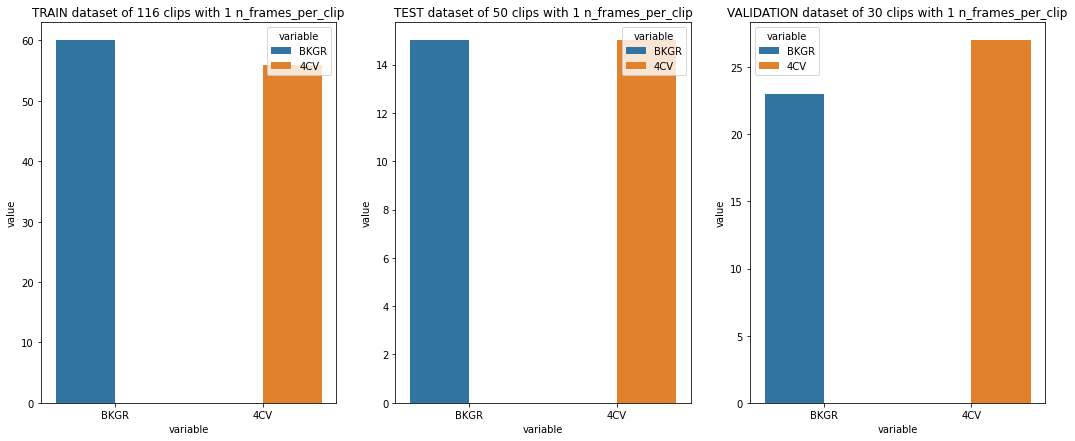

In [4]:
train_set_class_dict = get_class_distribution(train_set,label_id)
val_set_class_dict = get_class_distribution(validation_dataset,label_id)
test_set_class_dict = get_class_distribution(test_set,label_id)

print(f'class_distribution(train_set): {train_set_class_dict}')
print(f'class_distribution(validation_dataset): {val_set_class_dict}' )
print(f'class_distribution(test_set): {test_set_class_dict}')
    
#number_of_frames_per_segment_in_a_clip = config['number_of_frames_per_segment_in_a_clip']    
print(f'Number of frames for training datasets {len(train_set)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP}')
print(f'Number of frames for Validation datasets {len(validation_dataset)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP}')
print(f'Number of frames for testing datasets {len(test_set)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP}')

plot_title_train_label= f'TRAIN dataset of {len(train_set)} clips with {NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} n_frames_per_clip'
plot_title_val_label= f'VALIDATION dataset of {len(validation_dataset)} clips with {NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} n_frames_per_clip'
plot_title_test_label= f'TEST dataset of {len(test_set)} clips with {NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} n_frames_per_clip'

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,7))
plot_from_dict(train_set_class_dict, plot_title=plot_title_train_label, ax=axes[0])
plot_from_dict(val_set_class_dict, plot_title=plot_title_test_label, ax=axes[1])
plot_from_dict(test_set_class_dict, plot_title=plot_title_val_label, ax=axes[2])
plt.show()



## 4. Animating frames of one clip of the dataloader

In [5]:
print(f'---------------------------------------')
clips=creating_pair_of_clips(train_dataset, label_id)
pair_clips_and_labels = pair_clips_labels(clips)


---------------------------------------
 CLIP:00 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 108
 CLIP:01 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 123 from clip_frame_clip_idx 14
 CLIP:02 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 86
 CLIP:03 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 151 from clip_frame_clip_idx 52
 CLIP:04 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 102
 CLIP:05 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 121 from clip_frame_clip_idx 69
 CLIP:06 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 130
 CLIP:07 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 99
 CLIP:08 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 151 from clip_frame_clip_idx 110
 CLIP:09 of BKGR label for torch.Size(

 CLIP:145 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 182 from clip_frame_clip_idx 23
 CLIP:146 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 115 from clip_frame_clip_idx 37
 CLIP:147 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 96 from clip_frame_clip_idx 89
 CLIP:148 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 87 from clip_frame_clip_idx 66
 CLIP:149 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 98 from clip_frame_clip_idx 39
 CLIP:150 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 90 from clip_frame_clip_idx 10
 CLIP:151 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 152 from clip_frame_clip_idx 110
 CLIP:152 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 84 from clip_frame_clip_idx 66
 CLIP:153 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 110 from clip_frame_clip_idx 98
 CLIP:154 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 166 from clip_fr

<Figure size 432x288 with 0 Axes>

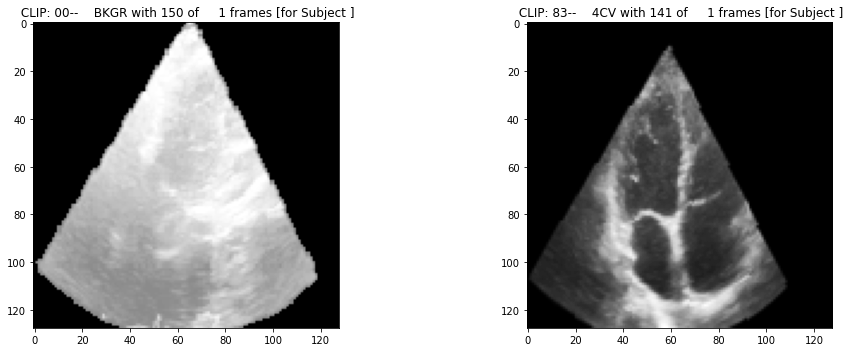

In [6]:
#average_HR =
#fps = 30
# 60 # beats per minute
#Beats-per-minute: 60 BPM
#Beats-per-second: 1 Hz
#Cycle-per-second: 1 (Cycle/s)

PAIR_OF_CLIPS = pair_clips_and_labels[0]

animated_frames=animate_clips(PAIR_OF_CLIPS, label_id, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP,
                  interval_between_frames_in_milliseconds)
HTML(animated_frames.to_jshtml())      


# ##SAVE ANIMATIONS
# for idx in range(0,len(pair_clips_labels)):
#     PAIR_OF_CLIPS = pair_clips_labels[idx]
#     print( f' pair_clips_labels {str(PAIR_OF_CLIPS[2])} {str(PAIR_OF_CLIPS[6])}')
    

## 5. Displayting frames in the dataloader

In [7]:

print(f'====================================================')
print(f'train_dataset.__len__() = {train_set.__len__()}')
train_dataloader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True,
    num_workers=0)


print(f'====================================================')
print(f'len(train_dataloader): {len(train_dataloader)} BATCHES of BATCH_SIZE_OF_CLIPS {BATCH_SIZE_OF_CLIPS}')
for clip_batch_idx, sample_batched in enumerate(train_dataloader):
    print(f'  ====================================================')
    sample_batched_images=sample_batched[0]
    sample_batched_labels=sample_batched[1]
    print(f'    BATCH_OF_CLIPS_INDEX : {clip_batch_idx} / {len(train_dataloader) - 1}')
    print(f'    sample_batched_labels.size(): {  sample_batched_labels.size()  }')
    print(f'    sample_batched_labels.squeeze().size(): {  sample_batched_labels.squeeze().size()  }')
    print(f'    sample_batched_images.size(): {sample_batched_images.size()}')

    for BATCH_SIZE_IDX, label in enumerate(sample_batched_labels):
        print(f'        BATCH_SIZE_IDX {BATCH_SIZE_IDX} ')
        print(f'          label: {label}')
        sample_batched_idx_image = sample_batched_images[BATCH_SIZE_IDX,...]
        print(f'          Sample_batched_idx_image.size()  {sample_batched_idx_image.size() }'  )

        grid = utils.make_grid(sample_batched_idx_image)
        print(f'          Grid size {grid.size()}' )
#         plt.figure(figsize =(20,20) )
#         plt.imshow( grid.cpu().detach().numpy().transpose(1, 2, 0) )
#         plt.title(f'BATCH_SIZE_IDX {BATCH_SIZE_IDX}; Label: {label_id[label]}')
#         plt.axis('off')
#         plt.ioff()
#         plt.show()


print(f'====================================================')
print(f' test_dataset.__len__() = {test_set.__len__()}')
test_dataloader = torch.utils.data.DataLoader(
    test_set, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)

print(f'====================================================')
print(f' validation_dataset.__len__() = {validation_dataset.__len__()}')
val_dataloader = torch.utils.data.DataLoader(
    validation_dataset, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)

train_dataset.__len__() = 116
len(train_dataloader): 9 BATCHES of BATCH_SIZE_OF_CLIPS 13
    BATCH_OF_CLIPS_INDEX : 0 / 8
    sample_batched_labels.size(): torch.Size([13])
    sample_batched_labels.squeeze().size(): torch.Size([13])
    sample_batched_images.size(): torch.Size([13, 1, 1, 128, 128])
        BATCH_SIZE_IDX 0 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 1 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 2 
          label: 1
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 3 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 4 
          label: 1
  

    BATCH_OF_CLIPS_INDEX : 8 / 8
    sample_batched_labels.size(): torch.Size([12])
    sample_batched_labels.squeeze().size(): torch.Size([12])
    sample_batched_images.size(): torch.Size([12, 1, 1, 128, 128])
        BATCH_SIZE_IDX 0 
          label: 1
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 1 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 2 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 3 
          label: 1
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 4 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size

## 7. Define networks
See `$HOMErepositories/echocardiography/source/models/arquitectures.py` to amend or implement other Neural Network Arquitectures!


## 8. Sanity checks for the model and dataloaders

In [8]:
##################################################################
##################################################################
##################################################################

##################################################################
##################################################################
##################################################################
##### Tensor Shape
#tensor_shape_size = [BATCH_SIZE_OF_CLIPS, config['number_of_frames_per_segment_in_a_clip'], 1, 128, 128]
#model = basicVGGNet(tensor_shape_size)

#n_frames_per_clip 
#model = VGG3D(PRETRANSFORM_IM_SIZE, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #print(config['pretransform_im_size']) #(128, 128)
#model = basicVGG(PRETRANSFORM_IM_SIZE, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #torch.Size([BATCH_SIZE_OF_CLIPS, CLASS_NUMBER])
#model = TrompNet2022(PRETRANSFORM_IM_SIZE, BATCH_SIZE_OF_CLIPS, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #print(config['pretransform_im_size']) #(128, 128)

# model=LeNet5_source00()#Total params: 6,350,946
# model=LeNet5_source01()#Total params: 1,627,790
# model=LeNet5_source02()#Total params: 1,741,026

# model = AlexNet_source00()#Total params: 56,996,546
# model = AlexNet_source01()#Total params: 24,714,626 
# model = AlexNet_source02()#Total params: 28,841,314
# model = AlexNet_source03(num_classes=2, in_channels=1)#Total params: 56,996,546 

model=MobileNetV1(ch_in=1, n_classes=2)#Total params: 3,208,450
# model=MobileNetV2(ch_in=1, n_classes=2)#Total params: 2,225,858



##TRIALS        
# model=ShuffleNetV1_G3()##RuntimeError: expected to have 3 channels
# model = shufflenetv2()##RuntimeError: expected to have 3 channels
# https://github.com/ntoussaint/fetalnav/blob/master/fetalnav/models/vgg.py
# model = VGG(cfg=VGGlayers, batch_norm=batch_norm, in_channels=1, num_classes=2)      
# model = ResNet(RNblock, RNlayers, num_classes=2, in_channels=1) #Total params: 21,279,426


model.to(DEVICE) # Place model on GPU

print(model) 
print(summary(model))
#print(str(summary(model, (1, 32, 32), depth=1)))

### Sanity check
#print(len(train_dataloader)) #6 BATCHES of 10=BATCH_SIZE_OF_CLIPS
sample_batched = next(iter(train_dataloader))
#print(sample_batched[0].shape) #torch.Size([10, 60, 1, 128, 128])
#print(sample_batched[1])#tensor([1, 1, 0, 0, 1, 1, 0, 1, 1, 1])
#print(sample_batched[2]) #tensor([47, 42,  0, 51, 49, 75, 67, 67, 62, 84])
#print(sample_batched[3]) #tensor([105, 102,  43, 106,  94, 161, 151, 183, 150, 151])

clip_batch = sample_batched[0]
#print(f'clip_batch.size() {clip_batch.size()}') ##torch.Size([4, 60, 1, 128, 128])
#                                                ##[batch_size, channels, depth, height, width]

# # frames = image.to(device)
print(f'Shape of vector: {model(clip_batch).shape}' ) #torch.Size([4, 2])
print(f'Type of variable  {type(model(clip_batch))}')  #torch.Size([4, 2]) #<class 'torch.Tensor'>

# #https://stackoverflow.com/questions/59129812/how-to-avoid-cuda-out-of-memory-in-pytorch
del sample_batched
torch.cuda.empty_cache()

MobileNetV1(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 128, kernel_size=(1, 1

Shape of vector: torch.Size([13, 2])
Type of variable  <class 'torch.Tensor'>


## 8. Define Optimizer
1. Set learning rate for how much the model is updated per batch.
2. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.
3. Set the number of clips per batch

In [9]:
#model = VGG3D(PRETRANSFORM_IM_SIZE, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #print(config['pretransform_im_size']) #(128, 128)
#model = basicVGG(PRETRANSFORM_IM_SIZE, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #torch.Size([BATCH_SIZE_OF_CLIPS, CLASS_NUMBER])
#model = TrompNet2022(PRETRANSFORM_IM_SIZE, BATCH_SIZE_OF_CLIPS, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #print(config['pretransform_im_size']) #(128, 128)
#optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ############################
# #### LeNet5_sourceNN
# # model=LeNet5_source00() #Total params: 6,350,946 ## Training curves look good: Reaching ACC~0.81; Loss~0.5
# model=LeNet5_source01() #Total params: 1,627,790 ## Training curves look good: Reaching ACC~0.93; Loss~0.5
# # model=LeNet5_source02() #Total params: 1,741,026  ## Training curves look good: Reaching ACC~0.80; Loss~0.5
# gamma=.001 #or0.002
# rho=.9 #LetNet_5()
# model.to(DEVICE) 
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum=rho) 
# #optimizer = torch.optim.RMSprop(model.parameters(), lr=gamma, momentum=rho) 
# LEARNING_RATE = gamma


# ###########################
# #### AlexNet
# # model = AlexNet_source00()#Total params: 56,996,546
# # model = AlexNet_source01()#Total params: 24,714,626 ## Training curves look good
# # model = AlexNet_source02()#Total params: 28,841,314 ## Training curves not converging
# # model = AlexNet_source03(num_classes=2, in_channels=1)#Total params: 56,996,546 [Training keeps 50%ACC in 1000epochs]
# #gamma=0.005#AlexNet
# gamma=0.001#AlexNet
# pshi=0.005#AlexNet
# rho=0.9#AlexNet
# model.to(DEVICE) 
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=gamma, weight_decay = pshi, momentum = rho)  #AlexNet
# LEARNING_RATE = gamma

###########################
#### MobileNetV1
#https://docs.netspresso.ai/docs/classification-mobilenet-v1-on-cifar100
model=MobileNetV1(ch_in=1, n_classes=2)#Total params: 3,208,450 ## Training curves look good
gamma=0.1
rho=0.9
model.to(DEVICE) # Place model on GPU
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum = rho) 
LEARNING_RATE = gamma


# ###########################
# #### MobileNetV2
# model=MobileNetV2(ch_in=1, n_classes=2)#Total params: 2,225,858 ## Training curves look good
# gamma=0.01
# #pshi=0.005
# rho=0.9
# model.to(DEVICE) # Place model on GPU
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum = rho) 
# LEARNING_RATE = gamma
# # A Flower Classification Approach with MobileNetV2 and Transfer Learning (2020)
# #   https://isciia2020.bit.edu.cn/docs/20201114083020836285.pdf                  


# ###########################
# #### MobileNetV2
# model=MobileNetV2(ch_in=1, n_classes=2)#Total params: 2,225,858 ## Training curves goes to ~ACC0.5; LOSS~>2 
# gamma=0.045 #Learning rate
# rho=0.9 # momentum
# lambda_ = 0.00004 # weight decay
# #learning rate decay rate of 0.98 per epoch?
# model.to(DEVICE) # Place model on GPU
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.RMSprop(model.parameters(), lr=gamma, momentum = rho, weight_decay=lambda_) 
# LEARNING_RATE = gamma
# # https://arxiv.org/pdf/1801.04381.pdf
# # https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html 

## OTHER REFERENCES ON MobileNetV2
# #https://github.com/d-li14/mobilenetv2.pytorch/issues/2#issuecomment-454282418
#torch.optim.SGD                    
# rho=0.001 #Learning rate #https://www.kaggle.com/code/gpiosenka/mobilenet-v2-transfer-learning-99-accuracy/notebook
# optimizer = torch.optim.Adam(lr=rho)


## PRINT MODEL
print(f'====================================================')
print(model)

# ### PRINT model.named_parameters
# print(f'====================================================')
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)



MobileNetV1(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 128, kernel_size=(1, 1

## 9. Training loop

In [10]:
### TRAINING
#clip_batch_size = tuple(train_dataloader.dataset.__getitem__(0)[0].shape) ##(60, 1, 128, 128) frames, chs, [width, height]
#print(clip_batch_size)


startt = time.time()
print(f'Starting training loop {startt}')


############################
####### BINARY ACCURACY MODULE
def binary_accuracy(y_pred, y_test):
    """
    binary_accuracy to calculate accuracy per epoch.
    """
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    accuracy = correct_results_sum/y_test.shape[0]
    accuracy = torch.round(accuracy * 100)
    return accuracy


############################
####### TRAIN LOOP MODULE
def train_loop(train_dataloader, model, criterion, optimizer, device):
    """
    train_loop
    Arguments:
        dataloader, model, criterion, optimizer, device

    Return:
        train_epoch_loss
    """
    train_epoch_loss = 0
    train_acc_loss_epoch = 0
    step_train = 0
    #size = len(train_dataloader.dataset)
    for clip_batch_idx, sample_batched in enumerate(train_dataloader):
        step_train += 1
        X_train_batch, y_train_batch = sample_batched[0].to(device), sample_batched[1].to(device)

        #print(f' BATCH_OF_CLIPS_INDEX: {clip_batch_idx} ')
        # print(f'----------------------------------------------------------')
        # print(f'   X_train_batch.size(): {X_train_batch.size()}') # torch.Size([9, 60, 1, 128, 128]) clips, frames, channels, [width, height]
        # print(f'   y_train_batch.size(): {y_train_batch.size()}') # torch.Size([9])

        # Compute prediction and loss
        y_train_pred = model(X_train_batch) #torch.Size([9, 2])
        #y_train_pred = model(X_train_batch).squeeze()  # torch.Size([9, 2])
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_accuracy(y_train_pred, y_train_batch)

        # Backpropagation
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # if clip_batch_idx % 10 == 0: ## Print loss values every 10 clip batches
        #     train_loss, current = train_loss.item(), clip_batch_idx * len(X_train_batch)
        #     print(f"loss: {train_loss:>7f}  [{current:>5d}/{size:>5d}]")

        train_epoch_loss += train_loss.detach().item()
        train_acc_loss_epoch += train_acc.detach().item()

    train_epoch_loss /= step_train
    train_acc_loss_epoch /= step_train

    return train_epoch_loss, train_acc_loss_epoch


############################
####### TEST LOOP MODULE
def test_loop(dataloader, model, criterion, device):
    """
    Test loop 
    
    Arguments:
        dataloader, model, criterion, optimizer, device

    Return:
        test_epoch_loss, correct
    """

    train_epoch_acc = 0
    step_test = 0
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_epoch_loss, correct = 0, 0

    with torch.no_grad():
        #model.eval()
        #val_epoch_loss = 0
        #val_epoch_acc = 0
        for clip_batch_idx, sample_val_batched in enumerate(dataloader):
            step_test += 1
            X_val_batch, y_val_batch = sample_val_batched[0].to(device), sample_val_batched[1].to(device)
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)
            test_epoch_loss += criterion(y_val_pred, y_val_batch).detach().item()
            correct += (y_val_pred.argmax(1) == y_val_batch).type(torch.float).sum().detach().item()

    test_epoch_loss /= num_batches
    correct /= size

    return test_epoch_loss, correct


#Dictionaries to store the accuracy/epoch and loss/epoch for both train and validation sets.
loss_stats = {
    'train': [],
    'test': [],
    #"val": []
}
accuracy_stats = {
    'train': [],
    'test': [],
    #"val": []
}

#for epoch in tqdm(range(1, MAX_EPOCHS)):   
for epoch in range(MAX_EPOCHS):
    print("-" * 10)
    print(f"EPOCH {epoch + 1}/{MAX_EPOCHS}")
    model.train()
    epoch_loss = 0
    step = 0
    
    
    train_epoch_loss, train_acc_loss_epoch = train_loop(train_dataloader, model, criterion, optimizer, DEVICE)
    
    
    model.eval()
    test_epoch_loss, correct = test_loop(val_dataloader, model, criterion, DEVICE)

    #print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} | Average Train Acc: {train_epoch_acc:.5f} | Average Validation Loss: {val_epoch_loss:.3f} | Average Validation Acc: {val_epoch_acc:.5f} ')
    #print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} |Average Train Acc: {train_epoch_acc:.5f}  ')
    
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_epoch_loss:>8f} \n")

    print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} Average Train Accuracy Loss: {(train_acc_loss_epoch):>0.1f}% ')
    
    print(f"Test Error: \n Test Accuracy: {(100*correct):>0.1f}%, Avg Test loss: {test_epoch_loss:>8f} \n")
    
    
    loss_stats['train'].append(train_epoch_loss)
    loss_stats['test'].append(test_epoch_loss)
    accuracy_stats['train'].append(train_acc_loss_epoch)
    accuracy_stats['test'].append(100*correct)
            
print("DONE TRAINING LOOP!")



endt = time.time()
elapsed_time = endt - startt
print(f'Finishing training loop {endt}')
print(f'Elapsed time for the training loop: {elapsed_time} (s)')

#model_path = ' /home/mx19/repositories/echocardiography/models' 
print(f' {FULL_REPO_MODEL_PATH}')
torch.save(model.state_dict(), os.path.join(FULL_REPO_MODEL_PATH, "metric_model.pth"))
print("Saved metric model")

print(loss_stats)
print(accuracy_stats)


Starting training loop 1659042279.5715458
----------
EPOCH 1/1000
Epoch 00: | Average Train Loss: 3.481 Average Train Accuracy Loss: 54.6% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 27.217737 

----------
EPOCH 2/1000
Epoch 01: | Average Train Loss: 5.637 Average Train Accuracy Loss: 47.4% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 21525.256510 

----------
EPOCH 3/1000
Epoch 02: | Average Train Loss: 3.528 Average Train Accuracy Loss: 50.8% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 10447.980143 

----------
EPOCH 4/1000
Epoch 03: | Average Train Loss: 1.525 Average Train Accuracy Loss: 43.9% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 39.536291 

----------
EPOCH 5/1000
Epoch 04: | Average Train Loss: 0.852 Average Train Accuracy Loss: 45.7% 
Test Error: 
 Test Accuracy: 63.3%, Avg Test loss: 6.601052 

----------
EPOCH 6/1000
Epoch 05: | Average Train Loss: 0.949 Average Train Accuracy Loss: 56.8% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss:

Epoch 51: | Average Train Loss: 0.611 Average Train Accuracy Loss: 65.0% 
Test Error: 
 Test Accuracy: 76.7%, Avg Test loss: 0.690729 

----------
EPOCH 53/1000
Epoch 52: | Average Train Loss: 0.574 Average Train Accuracy Loss: 68.2% 
Test Error: 
 Test Accuracy: 73.3%, Avg Test loss: 0.556671 

----------
EPOCH 54/1000
Epoch 53: | Average Train Loss: 0.582 Average Train Accuracy Loss: 71.4% 
Test Error: 
 Test Accuracy: 66.7%, Avg Test loss: 0.543946 

----------
EPOCH 55/1000
Epoch 54: | Average Train Loss: 0.668 Average Train Accuracy Loss: 63.0% 
Test Error: 
 Test Accuracy: 73.3%, Avg Test loss: 0.457745 

----------
EPOCH 56/1000
Epoch 55: | Average Train Loss: 0.681 Average Train Accuracy Loss: 59.6% 
Test Error: 
 Test Accuracy: 83.3%, Avg Test loss: 0.547857 

----------
EPOCH 57/1000
Epoch 56: | Average Train Loss: 0.678 Average Train Accuracy Loss: 56.8% 
Test Error: 
 Test Accuracy: 66.7%, Avg Test loss: 0.713690 

----------
EPOCH 58/1000
Epoch 57: | Average Train Loss: 0.

Epoch 102: | Average Train Loss: 0.560 Average Train Accuracy Loss: 69.2% 
Test Error: 
 Test Accuracy: 73.3%, Avg Test loss: 0.599483 

----------
EPOCH 104/1000
Epoch 103: | Average Train Loss: 0.545 Average Train Accuracy Loss: 72.6% 
Test Error: 
 Test Accuracy: 63.3%, Avg Test loss: 0.750902 

----------
EPOCH 105/1000
Epoch 104: | Average Train Loss: 0.554 Average Train Accuracy Loss: 74.3% 
Test Error: 
 Test Accuracy: 70.0%, Avg Test loss: 0.617991 

----------
EPOCH 106/1000
Epoch 105: | Average Train Loss: 0.511 Average Train Accuracy Loss: 74.2% 
Test Error: 
 Test Accuracy: 63.3%, Avg Test loss: 0.634471 

----------
EPOCH 107/1000
Epoch 106: | Average Train Loss: 0.501 Average Train Accuracy Loss: 76.1% 
Test Error: 
 Test Accuracy: 66.7%, Avg Test loss: 0.788141 

----------
EPOCH 108/1000
Epoch 107: | Average Train Loss: 0.499 Average Train Accuracy Loss: 78.3% 
Test Error: 
 Test Accuracy: 73.3%, Avg Test loss: 0.618331 

----------
EPOCH 109/1000
Epoch 108: | Average T

Epoch 153: | Average Train Loss: 0.488 Average Train Accuracy Loss: 73.4% 
Test Error: 
 Test Accuracy: 66.7%, Avg Test loss: 0.844507 

----------
EPOCH 155/1000
Epoch 154: | Average Train Loss: 0.501 Average Train Accuracy Loss: 73.4% 
Test Error: 
 Test Accuracy: 80.0%, Avg Test loss: 0.532160 

----------
EPOCH 156/1000
Epoch 155: | Average Train Loss: 0.513 Average Train Accuracy Loss: 78.6% 
Test Error: 
 Test Accuracy: 80.0%, Avg Test loss: 0.697339 

----------
EPOCH 157/1000
Epoch 156: | Average Train Loss: 0.458 Average Train Accuracy Loss: 77.4% 
Test Error: 
 Test Accuracy: 73.3%, Avg Test loss: 0.523431 

----------
EPOCH 158/1000
Epoch 157: | Average Train Loss: 0.460 Average Train Accuracy Loss: 82.0% 
Test Error: 
 Test Accuracy: 53.3%, Avg Test loss: 1.142876 

----------
EPOCH 159/1000
Epoch 158: | Average Train Loss: 0.481 Average Train Accuracy Loss: 73.9% 
Test Error: 
 Test Accuracy: 66.7%, Avg Test loss: 0.565036 

----------
EPOCH 160/1000
Epoch 159: | Average T

Epoch 204: | Average Train Loss: 0.501 Average Train Accuracy Loss: 75.1% 
Test Error: 
 Test Accuracy: 76.7%, Avg Test loss: 0.746327 

----------
EPOCH 206/1000
Epoch 205: | Average Train Loss: 0.523 Average Train Accuracy Loss: 73.3% 
Test Error: 
 Test Accuracy: 70.0%, Avg Test loss: 1.300694 

----------
EPOCH 207/1000
Epoch 206: | Average Train Loss: 0.518 Average Train Accuracy Loss: 73.1% 
Test Error: 
 Test Accuracy: 76.7%, Avg Test loss: 0.794538 

----------
EPOCH 208/1000
Epoch 207: | Average Train Loss: 0.572 Average Train Accuracy Loss: 75.3% 
Test Error: 
 Test Accuracy: 76.7%, Avg Test loss: 0.812619 

----------
EPOCH 209/1000
Epoch 208: | Average Train Loss: 0.481 Average Train Accuracy Loss: 76.0% 
Test Error: 
 Test Accuracy: 73.3%, Avg Test loss: 0.634658 

----------
EPOCH 210/1000
Epoch 209: | Average Train Loss: 0.471 Average Train Accuracy Loss: 77.6% 
Test Error: 
 Test Accuracy: 70.0%, Avg Test loss: 0.665797 

----------
EPOCH 211/1000
Epoch 210: | Average T

Epoch 255: | Average Train Loss: 0.426 Average Train Accuracy Loss: 81.3% 
Test Error: 
 Test Accuracy: 80.0%, Avg Test loss: 0.476046 

----------
EPOCH 257/1000
Epoch 256: | Average Train Loss: 0.477 Average Train Accuracy Loss: 78.6% 
Test Error: 
 Test Accuracy: 80.0%, Avg Test loss: 0.690740 

----------
EPOCH 258/1000
Epoch 257: | Average Train Loss: 0.434 Average Train Accuracy Loss: 79.2% 
Test Error: 
 Test Accuracy: 73.3%, Avg Test loss: 0.676638 

----------
EPOCH 259/1000
Epoch 258: | Average Train Loss: 0.516 Average Train Accuracy Loss: 74.1% 
Test Error: 
 Test Accuracy: 73.3%, Avg Test loss: 0.416897 

----------
EPOCH 260/1000
Epoch 259: | Average Train Loss: 0.499 Average Train Accuracy Loss: 75.1% 
Test Error: 
 Test Accuracy: 80.0%, Avg Test loss: 0.488890 

----------
EPOCH 261/1000
Epoch 260: | Average Train Loss: 0.514 Average Train Accuracy Loss: 73.3% 
Test Error: 
 Test Accuracy: 70.0%, Avg Test loss: 0.491487 

----------
EPOCH 262/1000
Epoch 261: | Average T

Epoch 306: | Average Train Loss: 0.432 Average Train Accuracy Loss: 80.1% 
Test Error: 
 Test Accuracy: 70.0%, Avg Test loss: 0.508267 

----------
EPOCH 308/1000
Epoch 307: | Average Train Loss: 0.472 Average Train Accuracy Loss: 77.8% 
Test Error: 
 Test Accuracy: 66.7%, Avg Test loss: 0.600719 

----------
EPOCH 309/1000
Epoch 308: | Average Train Loss: 0.448 Average Train Accuracy Loss: 80.2% 
Test Error: 
 Test Accuracy: 70.0%, Avg Test loss: 0.532375 

----------
EPOCH 310/1000
Epoch 309: | Average Train Loss: 0.420 Average Train Accuracy Loss: 82.2% 
Test Error: 
 Test Accuracy: 73.3%, Avg Test loss: 0.537730 

----------
EPOCH 311/1000
Epoch 310: | Average Train Loss: 0.417 Average Train Accuracy Loss: 80.2% 
Test Error: 
 Test Accuracy: 73.3%, Avg Test loss: 0.442408 

----------
EPOCH 312/1000
Epoch 311: | Average Train Loss: 0.457 Average Train Accuracy Loss: 77.6% 
Test Error: 
 Test Accuracy: 80.0%, Avg Test loss: 0.363358 

----------
EPOCH 313/1000
Epoch 312: | Average T

Epoch 357: | Average Train Loss: 0.520 Average Train Accuracy Loss: 75.9% 
Test Error: 
 Test Accuracy: 76.7%, Avg Test loss: 0.529670 

----------
EPOCH 359/1000
Epoch 358: | Average Train Loss: 0.425 Average Train Accuracy Loss: 82.0% 
Test Error: 
 Test Accuracy: 76.7%, Avg Test loss: 0.542885 

----------
EPOCH 360/1000
Epoch 359: | Average Train Loss: 0.402 Average Train Accuracy Loss: 80.0% 
Test Error: 
 Test Accuracy: 76.7%, Avg Test loss: 0.512148 

----------
EPOCH 361/1000
Epoch 360: | Average Train Loss: 0.473 Average Train Accuracy Loss: 77.7% 
Test Error: 
 Test Accuracy: 56.7%, Avg Test loss: 0.684098 

----------
EPOCH 362/1000
Epoch 361: | Average Train Loss: 0.397 Average Train Accuracy Loss: 82.1% 
Test Error: 
 Test Accuracy: 73.3%, Avg Test loss: 0.571558 

----------
EPOCH 363/1000
Epoch 362: | Average Train Loss: 0.457 Average Train Accuracy Loss: 76.8% 
Test Error: 
 Test Accuracy: 76.7%, Avg Test loss: 0.750878 

----------
EPOCH 364/1000
Epoch 363: | Average T

Epoch 408: | Average Train Loss: 0.434 Average Train Accuracy Loss: 79.3% 
Test Error: 
 Test Accuracy: 76.7%, Avg Test loss: 0.626307 

----------
EPOCH 410/1000
Epoch 409: | Average Train Loss: 0.392 Average Train Accuracy Loss: 82.6% 
Test Error: 
 Test Accuracy: 70.0%, Avg Test loss: 1.320652 

----------
EPOCH 411/1000
Epoch 410: | Average Train Loss: 0.448 Average Train Accuracy Loss: 76.9% 
Test Error: 
 Test Accuracy: 73.3%, Avg Test loss: 0.423045 

----------
EPOCH 412/1000
Epoch 411: | Average Train Loss: 0.425 Average Train Accuracy Loss: 78.7% 
Test Error: 
 Test Accuracy: 73.3%, Avg Test loss: 0.657728 

----------
EPOCH 413/1000
Epoch 412: | Average Train Loss: 0.391 Average Train Accuracy Loss: 82.8% 
Test Error: 
 Test Accuracy: 66.7%, Avg Test loss: 0.662706 

----------
EPOCH 414/1000
Epoch 413: | Average Train Loss: 0.452 Average Train Accuracy Loss: 83.0% 
Test Error: 
 Test Accuracy: 83.3%, Avg Test loss: 0.346817 

----------
EPOCH 415/1000
Epoch 414: | Average T

Epoch 459: | Average Train Loss: 0.398 Average Train Accuracy Loss: 83.8% 
Test Error: 
 Test Accuracy: 76.7%, Avg Test loss: 0.376059 

----------
EPOCH 461/1000
Epoch 460: | Average Train Loss: 0.485 Average Train Accuracy Loss: 75.9% 
Test Error: 
 Test Accuracy: 73.3%, Avg Test loss: 0.505464 

----------
EPOCH 462/1000
Epoch 461: | Average Train Loss: 0.362 Average Train Accuracy Loss: 84.3% 
Test Error: 
 Test Accuracy: 73.3%, Avg Test loss: 0.397210 

----------
EPOCH 463/1000
Epoch 462: | Average Train Loss: 0.473 Average Train Accuracy Loss: 77.4% 
Test Error: 
 Test Accuracy: 76.7%, Avg Test loss: 0.525774 

----------
EPOCH 464/1000
Epoch 463: | Average Train Loss: 0.404 Average Train Accuracy Loss: 83.0% 
Test Error: 
 Test Accuracy: 80.0%, Avg Test loss: 0.462996 

----------
EPOCH 465/1000
Epoch 464: | Average Train Loss: 0.416 Average Train Accuracy Loss: 81.1% 
Test Error: 
 Test Accuracy: 70.0%, Avg Test loss: 0.533147 

----------
EPOCH 466/1000
Epoch 465: | Average T

Epoch 510: | Average Train Loss: 0.369 Average Train Accuracy Loss: 84.3% 
Test Error: 
 Test Accuracy: 80.0%, Avg Test loss: 0.593776 

----------
EPOCH 512/1000
Epoch 511: | Average Train Loss: 0.433 Average Train Accuracy Loss: 80.4% 
Test Error: 
 Test Accuracy: 70.0%, Avg Test loss: 0.525613 

----------
EPOCH 513/1000
Epoch 512: | Average Train Loss: 0.401 Average Train Accuracy Loss: 81.9% 
Test Error: 
 Test Accuracy: 80.0%, Avg Test loss: 0.506389 

----------
EPOCH 514/1000
Epoch 513: | Average Train Loss: 0.467 Average Train Accuracy Loss: 78.4% 
Test Error: 
 Test Accuracy: 76.7%, Avg Test loss: 0.452704 

----------
EPOCH 515/1000
Epoch 514: | Average Train Loss: 0.443 Average Train Accuracy Loss: 81.2% 
Test Error: 
 Test Accuracy: 80.0%, Avg Test loss: 0.474372 

----------
EPOCH 516/1000
Epoch 515: | Average Train Loss: 0.412 Average Train Accuracy Loss: 82.8% 
Test Error: 
 Test Accuracy: 70.0%, Avg Test loss: 0.534746 

----------
EPOCH 517/1000
Epoch 516: | Average T

Epoch 561: | Average Train Loss: 0.369 Average Train Accuracy Loss: 83.7% 
Test Error: 
 Test Accuracy: 73.3%, Avg Test loss: 0.621590 

----------
EPOCH 563/1000
Epoch 562: | Average Train Loss: 0.389 Average Train Accuracy Loss: 82.1% 
Test Error: 
 Test Accuracy: 80.0%, Avg Test loss: 0.432958 

----------
EPOCH 564/1000
Epoch 563: | Average Train Loss: 0.350 Average Train Accuracy Loss: 84.3% 
Test Error: 
 Test Accuracy: 73.3%, Avg Test loss: 0.536934 

----------
EPOCH 565/1000
Epoch 564: | Average Train Loss: 0.370 Average Train Accuracy Loss: 84.6% 
Test Error: 
 Test Accuracy: 73.3%, Avg Test loss: 0.423941 

----------
EPOCH 566/1000
Epoch 565: | Average Train Loss: 0.464 Average Train Accuracy Loss: 78.6% 
Test Error: 
 Test Accuracy: 76.7%, Avg Test loss: 0.484924 

----------
EPOCH 567/1000
Epoch 566: | Average Train Loss: 0.388 Average Train Accuracy Loss: 81.9% 
Test Error: 
 Test Accuracy: 73.3%, Avg Test loss: 0.518026 

----------
EPOCH 568/1000
Epoch 567: | Average T

Epoch 612: | Average Train Loss: 0.443 Average Train Accuracy Loss: 78.4% 
Test Error: 
 Test Accuracy: 73.3%, Avg Test loss: 0.693551 

----------
EPOCH 614/1000
Epoch 613: | Average Train Loss: 0.376 Average Train Accuracy Loss: 83.9% 
Test Error: 
 Test Accuracy: 76.7%, Avg Test loss: 0.653384 

----------
EPOCH 615/1000
Epoch 614: | Average Train Loss: 0.340 Average Train Accuracy Loss: 86.4% 
Test Error: 
 Test Accuracy: 63.3%, Avg Test loss: 0.754753 

----------
EPOCH 616/1000
Epoch 615: | Average Train Loss: 0.283 Average Train Accuracy Loss: 89.0% 
Test Error: 
 Test Accuracy: 53.3%, Avg Test loss: 1.582003 

----------
EPOCH 617/1000
Epoch 616: | Average Train Loss: 0.440 Average Train Accuracy Loss: 78.7% 
Test Error: 
 Test Accuracy: 66.7%, Avg Test loss: 1.098117 

----------
EPOCH 618/1000
Epoch 617: | Average Train Loss: 0.388 Average Train Accuracy Loss: 82.0% 
Test Error: 
 Test Accuracy: 76.7%, Avg Test loss: 0.575923 

----------
EPOCH 619/1000
Epoch 618: | Average T

Epoch 663: | Average Train Loss: 0.442 Average Train Accuracy Loss: 81.9% 
Test Error: 
 Test Accuracy: 83.3%, Avg Test loss: 0.494140 

----------
EPOCH 665/1000
Epoch 664: | Average Train Loss: 0.351 Average Train Accuracy Loss: 86.1% 
Test Error: 
 Test Accuracy: 70.0%, Avg Test loss: 0.661923 

----------
EPOCH 666/1000
Epoch 665: | Average Train Loss: 0.402 Average Train Accuracy Loss: 82.7% 
Test Error: 
 Test Accuracy: 60.0%, Avg Test loss: 0.878161 

----------
EPOCH 667/1000
Epoch 666: | Average Train Loss: 0.392 Average Train Accuracy Loss: 81.0% 
Test Error: 
 Test Accuracy: 66.7%, Avg Test loss: 0.674498 

----------
EPOCH 668/1000
Epoch 667: | Average Train Loss: 0.404 Average Train Accuracy Loss: 80.1% 
Test Error: 
 Test Accuracy: 63.3%, Avg Test loss: 0.532309 

----------
EPOCH 669/1000
Epoch 668: | Average Train Loss: 0.440 Average Train Accuracy Loss: 83.0% 
Test Error: 
 Test Accuracy: 63.3%, Avg Test loss: 1.007619 

----------
EPOCH 670/1000
Epoch 669: | Average T

Epoch 714: | Average Train Loss: 0.402 Average Train Accuracy Loss: 80.3% 
Test Error: 
 Test Accuracy: 70.0%, Avg Test loss: 0.879430 

----------
EPOCH 716/1000
Epoch 715: | Average Train Loss: 0.403 Average Train Accuracy Loss: 79.2% 
Test Error: 
 Test Accuracy: 73.3%, Avg Test loss: 1.067596 

----------
EPOCH 717/1000
Epoch 716: | Average Train Loss: 0.386 Average Train Accuracy Loss: 82.7% 
Test Error: 
 Test Accuracy: 73.3%, Avg Test loss: 0.631648 

----------
EPOCH 718/1000
Epoch 717: | Average Train Loss: 0.407 Average Train Accuracy Loss: 83.0% 
Test Error: 
 Test Accuracy: 70.0%, Avg Test loss: 0.713959 

----------
EPOCH 719/1000
Epoch 718: | Average Train Loss: 0.387 Average Train Accuracy Loss: 82.7% 
Test Error: 
 Test Accuracy: 70.0%, Avg Test loss: 0.670039 

----------
EPOCH 720/1000
Epoch 719: | Average Train Loss: 0.384 Average Train Accuracy Loss: 82.9% 
Test Error: 
 Test Accuracy: 60.0%, Avg Test loss: 0.539886 

----------
EPOCH 721/1000
Epoch 720: | Average T

Epoch 765: | Average Train Loss: 0.319 Average Train Accuracy Loss: 86.2% 
Test Error: 
 Test Accuracy: 73.3%, Avg Test loss: 0.600869 

----------
EPOCH 767/1000
Epoch 766: | Average Train Loss: 0.303 Average Train Accuracy Loss: 89.6% 
Test Error: 
 Test Accuracy: 66.7%, Avg Test loss: 0.610362 

----------
EPOCH 768/1000
Epoch 767: | Average Train Loss: 0.457 Average Train Accuracy Loss: 82.8% 
Test Error: 
 Test Accuracy: 70.0%, Avg Test loss: 0.835993 

----------
EPOCH 769/1000
Epoch 768: | Average Train Loss: 0.407 Average Train Accuracy Loss: 79.6% 
Test Error: 
 Test Accuracy: 70.0%, Avg Test loss: 0.610058 

----------
EPOCH 770/1000
Epoch 769: | Average Train Loss: 0.409 Average Train Accuracy Loss: 78.6% 
Test Error: 
 Test Accuracy: 63.3%, Avg Test loss: 0.537352 

----------
EPOCH 771/1000
Epoch 770: | Average Train Loss: 0.332 Average Train Accuracy Loss: 82.9% 
Test Error: 
 Test Accuracy: 66.7%, Avg Test loss: 0.619760 

----------
EPOCH 772/1000
Epoch 771: | Average T

Epoch 816: | Average Train Loss: 0.394 Average Train Accuracy Loss: 85.2% 
Test Error: 
 Test Accuracy: 63.3%, Avg Test loss: 0.651858 

----------
EPOCH 818/1000
Epoch 817: | Average Train Loss: 0.360 Average Train Accuracy Loss: 83.6% 
Test Error: 
 Test Accuracy: 70.0%, Avg Test loss: 0.537664 

----------
EPOCH 819/1000
Epoch 818: | Average Train Loss: 0.351 Average Train Accuracy Loss: 80.9% 
Test Error: 
 Test Accuracy: 70.0%, Avg Test loss: 0.515332 

----------
EPOCH 820/1000
Epoch 819: | Average Train Loss: 0.368 Average Train Accuracy Loss: 79.4% 
Test Error: 
 Test Accuracy: 70.0%, Avg Test loss: 0.528527 

----------
EPOCH 821/1000
Epoch 820: | Average Train Loss: 0.333 Average Train Accuracy Loss: 87.2% 
Test Error: 
 Test Accuracy: 70.0%, Avg Test loss: 0.576806 

----------
EPOCH 822/1000
Epoch 821: | Average Train Loss: 0.384 Average Train Accuracy Loss: 81.8% 
Test Error: 
 Test Accuracy: 70.0%, Avg Test loss: 0.458134 

----------
EPOCH 823/1000
Epoch 822: | Average T

Epoch 867: | Average Train Loss: 0.347 Average Train Accuracy Loss: 86.1% 
Test Error: 
 Test Accuracy: 76.7%, Avg Test loss: 0.591541 

----------
EPOCH 869/1000
Epoch 868: | Average Train Loss: 0.320 Average Train Accuracy Loss: 88.6% 
Test Error: 
 Test Accuracy: 63.3%, Avg Test loss: 1.014581 

----------
EPOCH 870/1000
Epoch 869: | Average Train Loss: 0.357 Average Train Accuracy Loss: 86.2% 
Test Error: 
 Test Accuracy: 73.3%, Avg Test loss: 1.119873 

----------
EPOCH 871/1000
Epoch 870: | Average Train Loss: 0.367 Average Train Accuracy Loss: 85.2% 
Test Error: 
 Test Accuracy: 63.3%, Avg Test loss: 0.742830 

----------
EPOCH 872/1000
Epoch 871: | Average Train Loss: 0.346 Average Train Accuracy Loss: 85.4% 
Test Error: 
 Test Accuracy: 60.0%, Avg Test loss: 1.324177 

----------
EPOCH 873/1000
Epoch 872: | Average Train Loss: 0.437 Average Train Accuracy Loss: 81.1% 
Test Error: 
 Test Accuracy: 56.7%, Avg Test loss: 0.999386 

----------
EPOCH 874/1000
Epoch 873: | Average T

Epoch 918: | Average Train Loss: 0.323 Average Train Accuracy Loss: 85.4% 
Test Error: 
 Test Accuracy: 63.3%, Avg Test loss: 0.704126 

----------
EPOCH 920/1000
Epoch 919: | Average Train Loss: 0.365 Average Train Accuracy Loss: 81.9% 
Test Error: 
 Test Accuracy: 60.0%, Avg Test loss: 1.054159 

----------
EPOCH 921/1000
Epoch 920: | Average Train Loss: 0.321 Average Train Accuracy Loss: 84.8% 
Test Error: 
 Test Accuracy: 63.3%, Avg Test loss: 1.063946 

----------
EPOCH 922/1000
Epoch 921: | Average Train Loss: 0.323 Average Train Accuracy Loss: 82.9% 
Test Error: 
 Test Accuracy: 73.3%, Avg Test loss: 0.708779 

----------
EPOCH 923/1000
Epoch 922: | Average Train Loss: 0.305 Average Train Accuracy Loss: 86.4% 
Test Error: 
 Test Accuracy: 63.3%, Avg Test loss: 0.903414 

----------
EPOCH 924/1000
Epoch 923: | Average Train Loss: 0.350 Average Train Accuracy Loss: 85.3% 
Test Error: 
 Test Accuracy: 66.7%, Avg Test loss: 1.230600 

----------
EPOCH 925/1000
Epoch 924: | Average T

Epoch 969: | Average Train Loss: 0.331 Average Train Accuracy Loss: 85.4% 
Test Error: 
 Test Accuracy: 80.0%, Avg Test loss: 0.486835 

----------
EPOCH 971/1000
Epoch 970: | Average Train Loss: 0.366 Average Train Accuracy Loss: 82.0% 
Test Error: 
 Test Accuracy: 66.7%, Avg Test loss: 0.625722 

----------
EPOCH 972/1000
Epoch 971: | Average Train Loss: 0.398 Average Train Accuracy Loss: 80.9% 
Test Error: 
 Test Accuracy: 70.0%, Avg Test loss: 0.714888 

----------
EPOCH 973/1000
Epoch 972: | Average Train Loss: 0.392 Average Train Accuracy Loss: 80.3% 
Test Error: 
 Test Accuracy: 70.0%, Avg Test loss: 0.622067 

----------
EPOCH 974/1000
Epoch 973: | Average Train Loss: 0.373 Average Train Accuracy Loss: 83.0% 
Test Error: 
 Test Accuracy: 70.0%, Avg Test loss: 0.851482 

----------
EPOCH 975/1000
Epoch 974: | Average Train Loss: 0.341 Average Train Accuracy Loss: 83.7% 
Test Error: 
 Test Accuracy: 66.7%, Avg Test loss: 0.901701 

----------
EPOCH 976/1000
Epoch 975: | Average T

## 10. Visualize accuracy and loss performance and storage

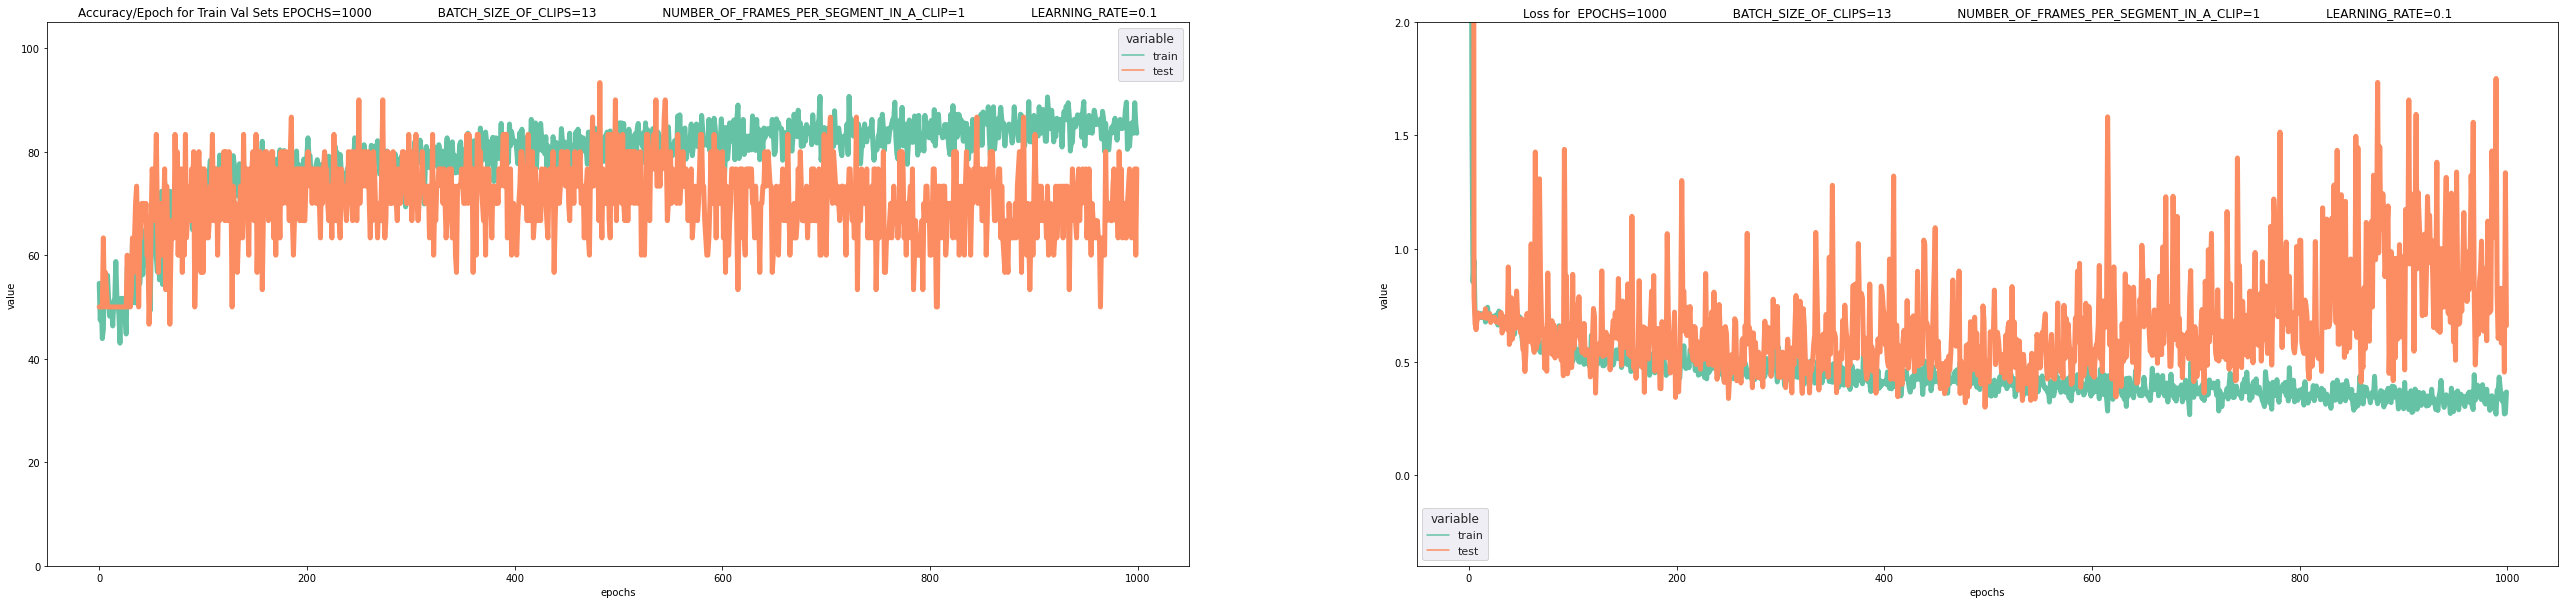

In [11]:
## Convert stats as dataframes
loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
## Concatenate dataframes and dictionaries
loss_df.insert(0, 'curve', 'Loss', True)
acc_df.insert(0, 'curve', 'Acc', True)
valuesall = [loss_df, acc_df]
values_all = pd.concat(valuesall)

all_stats = {
    'ACC': accuracy_stats,
    'LOS': loss_stats,
}


## Saving training curves at $HOME/repositories/echocardiography/scripts/learning-pipeline/results
os.chdir(TRAINING_CURVES_PATH)


#################################
#### PLOTING
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45,10))
sns.set(style="darkgrid")
sns.lineplot(
    data=acc_df, 
    x = "epochs", y="value", hue="variable",  ax=axes[0],    
    estimator=None, linewidth=5, palette="Set2" 
    ).set_title(f'Accuracy/Epoch for Train Val Sets EPOCHS={MAX_EPOCHS} \
                BATCH_SIZE_OF_CLIPS={BATCH_SIZE_OF_CLIPS} \
                NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP={NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} \
                LEARNING_RATE={LEARNING_RATE}')

axes[0].set_ylim(0,105)

sns.set(style="darkgrid")
sns.lineplot(
    data=loss_df, 
    x = "epochs", y="value", hue="variable", ax=axes[1],
    estimator=None, linewidth=5, palette="Set2" 
    ).set_title(f'Loss for  EPOCHS={MAX_EPOCHS} \
                BATCH_SIZE_OF_CLIPS={BATCH_SIZE_OF_CLIPS} \
                NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP={NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} \
                LEARNING_RATE={LEARNING_RATE}')
axes[1].set_ylim(-0.4, 2)



#### PREPARING AND SAVING PERFORMANCE CURVES
WIDTH = 3
PRECISION = 10
TYPE = "f"
STR_LR = f'{LEARNING_RATE:{WIDTH}.{PRECISION}{TYPE}}'
STR_LR = STR_LR.replace(".", "_", 1)

PARAMETERS_FILENAME = "TRAINset_clips_"+ \
                    str(len(train_set))+"TESTset_clips_"+ \
                    str(len(test_set))+"VALset_clips"+ \
                    str(len(validation_dataset))+"___EPOCHS_"+str(f'{MAX_EPOCHS:{WIDTH}}') + \
                    "_BATCH_SIZE_OF_CLIPS_"+str(f'{BATCH_SIZE_OF_CLIPS:02}')+ \
                    "_NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP_"+ \
                    str(NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP)+"_LEARNING_RATE_"+STR_LR

## Saving training curves at $HOME/repositories/echocardiography/scripts/learning-pipeline/results
os.chdir(TRAINING_CURVES_PATH)
TEMP_DICT_TRAINING_CURVES_FOR = "TEMP_DICT_TRAINING_CURVES_FOR____"
IMAGE_FILE_NAME = TEMP_DICT_TRAINING_CURVES_FOR+PARAMETERS_FILENAME
#print(IMAGE_FILE_NAME)
fig.savefig(IMAGE_FILE_NAME) 

## Saving training metrics in dictionaries at $HOME/repositories/echocardiography/scripts/learning-pipeline/results
LOSS_ACC_DICTS_FILE_NAME = "TEMP_DICT_TRAINING_CURVES_FOR____"+"_LOSS_ACC_"+PARAMETERS_FILENAME+'.json'
#print(LOSS_ACC_DICTS_FILE_NAME)
#print(all_stats)

with open(LOSS_ACC_DICTS_FILE_NAME, 'w') as file:
   file.write(json.dumps(all_stats, indent=2))
    


## 11. Evaluate the model on test dataset

In [12]:
model.load_state_dict(torch.load(
    os.path.join(FULL_REPO_MODEL_PATH, "metric_model.pth")))
model.eval()

y_true_list = []
y_pred_list = []

with torch.no_grad():
    for clip_batch_idx, sample_batched in enumerate(test_dataloader):
        X_train_batch, y_train_batch = sample_batched[0].to(DEVICE), sample_batched[1].to(DEVICE)
        print(f'==================================================')
        print(f' BATCH_OF_CLIPS_INDEX: {clip_batch_idx} ')
        print(f'   X_train_batch.size(): {X_train_batch.size()}') # torch.Size([9, 60, 1, 128, 128]) clips, frames, channels, [width, height]
        print(f'   y_train_batch.size(): {y_train_batch.size()}') # torch.Size([9])

        y_test_pred = model(X_train_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)        
        
        for i in range(len(y_test_pred)):
            y_true_list.append(y_train_batch[i].cpu().item())
            y_pred_list.append(y_pred_tag[i].cpu().item())
            
        
print(f'==================================================')        
print(f'==================================================')        
print(get_class_distribution(test_set, label_id))
print(f'y_true_list{y_true_list}')
print(f'y_pred_list{y_pred_list}')



 BATCH_OF_CLIPS_INDEX: 0 
   X_train_batch.size(): torch.Size([13, 1, 1, 128, 128])
   y_train_batch.size(): torch.Size([13])
 BATCH_OF_CLIPS_INDEX: 1 
   X_train_batch.size(): torch.Size([13, 1, 1, 128, 128])
   y_train_batch.size(): torch.Size([13])
 BATCH_OF_CLIPS_INDEX: 2 
   X_train_batch.size(): torch.Size([13, 1, 1, 128, 128])
   y_train_batch.size(): torch.Size([13])
 BATCH_OF_CLIPS_INDEX: 3 
   X_train_batch.size(): torch.Size([11, 1, 1, 128, 128])
   y_train_batch.size(): torch.Size([11])
{'BKGR': 23, '4CV': 27}
y_true_list[1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1]
y_pred_list[0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1]


              precision    recall  f1-score   support

           0       0.74      0.87      0.80        23
           1       0.87      0.74      0.80        27

    accuracy                           0.80        50
   macro avg       0.81      0.81      0.80        50
weighted avg       0.81      0.80      0.80        50

                    Precision    Recall  F1-score  Support
0                    0.740741  0.869565       0.8     23.0
1                    0.869565  0.740741       0.8     27.0
weighted avg/Total   0.810306  0.800000       0.8      NaN
Avg/Total                 NaN       NaN       NaN     50.0
[[20  3]
 [ 7 20]]


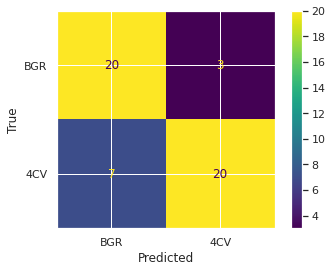

In [13]:
report = classification_report(y_true_list, y_pred_list)
print(report)
# report_support = precision_recall_fscore_support(y_true_list, y_pred_list)
# print(report_support)

def metrics_report_to_df(ytrue, ypred):
    classification_report_df = pd.DataFrame(data=list(precision_recall_fscore_support(y_true_list, y_pred_list)), \
                                         index=['Precision', 'Recall', 'F1-score', 'Support']).T    
    classification_report_df.loc['weighted avg/Total', :] = precision_recall_fscore_support(ytrue, ypred, average='weighted')
    classification_report_df.loc['Avg/Total', 'Support'] = classification_report_df['Support'].sum()
    return(classification_report_df)

classification_report_df = metrics_report_to_df(y_true_list, y_pred_list)
print(classification_report_df)

#################################
### PLOTTING CONFUSION MATRIX
cm=confusion_matrix(y_true_list, y_pred_list)
print(cm)
#cm=confusion_matrix(y_true_list, y_pred_list, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['BGR','4CV'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')


#### PREPARING AND SAVING TRAINING PERFORMANCE PARAMETERS
train_values = {} # instantiate an empty train_values dict 
train_values['elapsed_time_in_secs'] = elapsed_time
train_values['MAX_EPOCHS'] = MAX_EPOCHS
train_values['LEARNING_RATE'] = LEARNING_RATE
train_values['BATCH_SIZE_OF_CLIPS'] = BATCH_SIZE_OF_CLIPS
train_values['PRETRANSFORM_IM_SIZE'] = PRETRANSFORM_IM_SIZE
train_values['FRAMES_PER_CLIP'] = NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP
train_values['Train Dataset Size'] = len(train_set)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP*BATCH_SIZE_OF_CLIPS
train_values['Test Dataset Size'] = len(test_set)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP*BATCH_SIZE_OF_CLIPS
train_values['Validation Dataset Size'] = len(validation_dataset)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP*BATCH_SIZE_OF_CLIPS
train_values['Current date and time'] = datetime.now().strftime('%dD-%mM-%yY_%HH-%MM-%SS')
train_values['Classification Report']=classification_report_df.head().to_dict()
train_values['Arquitecture']=(str(model)[:])#.head().to_dict()

#team['konqi'] = {'health': 18, 'level': 7}

## Saving training curves at $HOME/repositories/echocardiography/scripts/learning-pipeline/results
os.chdir(TRAINING_CURVES_PATH)
TRAIN_FILE_NAME = TEMP_DICT_TRAINING_CURVES_FOR+"TRAINING_PARAMETERS"+PARAMETERS_FILENAME+".json"


with open(TRAIN_FILE_NAME, 'w') as file:
     file.write(json.dumps(train_values, indent=4))

        


## 12. [**!WARNING!**] Cleanup temporal data directory 
Remove directory if a temporary was used.

```
       Make sure you know which path you will remove as you do not like to remove important files.
       shutil.rmtree
```

In [14]:
temporal_files_path = config['temporal_data_path']

shutil.rmtree(temporal_files_path)
print(f' {temporal_files_path} is empty')

 /home/mx19/datasets/vital-us/echocardiography/temporal-files/ is empty
